# Simulation Grid

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fitsio

Define the simulation parameter grid:

In [3]:
g_grid = np.linspace(22.0, 23.0, 5)
z_grid = np.linspace(1.0, 3.5, 11)

Read the per-camera files produced by `qso_grid.py`:

In [4]:
def read_camera(band):
    fits = fitsio.FITS('../simulate/{}.fits'.format(band), mode='r')
    flux = fits[0].read()
    ivar = fits[1].read()
    wlen = fits[2].read()
    fits.close()
    return flux, ivar, wlen

In [5]:
b_flux, b_ivar, b_wlen = read_camera('b')
r_flux, r_ivar, r_wlen = read_camera('r')
z_flux, z_ivar, z_wlen = read_camera('z')

In [6]:
def plot(g_index, z_index, save=None):
    # Lookup the grid parameters for this spectrum.
    try:
        g, z = g_grid[g_index], z_grid[z_index]
    except IndexError:
        print 'Invalid g_index, z_index.'
        return
    print 'g = {:.2f}, z = {:.2f}'.format(g, z)
    spec_index = g_index * len(z_grid) + z_index

    # Plot each camera's flux w/o error bars.
    plt.plot(b_wlen[spec_index], b_flux[spec_index], 'b.', alpha=0.5)
    plt.plot(r_wlen[spec_index], r_flux[spec_index], 'r.', alpha=0.5)
    plt.plot(z_wlen[spec_index], z_flux[spec_index], 'k.', alpha=0.5)
    plt.xlabel('Wavelength')
    plt.ylabel('Flux 1e-17 ergs/cm**2/s/A')
    plt.xlim(3500., 10000.)
    
    # Pick suitable y limits.
    all_flux = np.hstack([b_flux[spec_index], r_flux[spec_index], z_flux[spec_index]]).flatten()
    ymin, ymax = np.percentile(all_flux, (1., 99.))
    plt.ylim(ymin, ymax)
    
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()

g = 23.00, z = 2.50


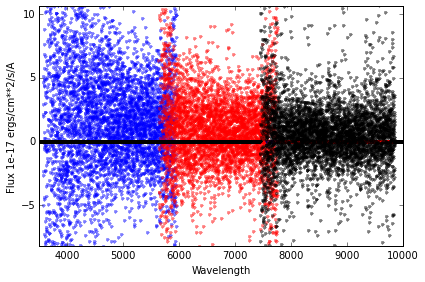

In [7]:
plot(4, 6, 'qso-23-2.5.png')